In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

matplotlib.style.use('ggplot')
%matplotlib inline

CPAT uses logistic regression model based on 4 pure sequence-based, linguistic features

* ORF size
* ORF coverage = ORF_size/mRNA_size
* Fickett TESTCODE
* Hexamer usage bias

Linguistic features based method does not require other genomes or protein databases to perform alignment and is more robust. Because it is alignment free, it runs much faster and also easier to use. For example, CPAT only took several minutes to evaluate the above 14,000 lncRNAs. More importantly, compared with alignment-based approaches, CPAT achieves better sensitivity and specificity (0.966 tested on human gene annotation).

# Data preprocessing

In [5]:
!ls -lh ../data/

total 1.2G
-rw-r--r-- 1 fogside fogside 151M Aug 11 22:40 hg19_description.gtf
-rw-r--r-- 1 fogside fogside 228M Aug  4 22:55 hg38_description.gtf
-rw-rw-r-- 1 fogside fogside  19K Aug  4 22:50 hg38.fa.fai
-rw-rw-r-- 1 fogside fogside 217M Aug 11 22:41 known_genes_19.fasta
-rw-rw-r-- 1 fogside fogside 294M Aug  4 22:56 known_genes_38.fasta
-rw-rw-r-- 1 fogside fogside 115M Jan 15  2015 lncipedia_3_1.fasta
-rw-rw-r-- 1 fogside fogside  79M Feb  6  2015 lncipedia_3_1_hc.fasta
-rw-rw-r-- 1 fogside fogside  79M May 24 12:20 lncipedia_4_0_hc.fasta
-rw-rw-r-- 1 fogside fogside  48M May 24 12:11 lncipedia_4_0_hc_hg38.gff
-rw-r--r-- 1 fogside fogside 3.5M Aug 11 22:49 lncrna_features.txt
-rw-rw-r-- 1 fogside fogside 3.4M Aug 11 23:02 mrna_features.txt


In [14]:
lncRNA = pd.read_csv("../data/lncrna_features.txt", sep = '\t', index_col=0)
lncRNA["TYPE"] = [0]*len(lncRNA)
print(len(lncRNA))
lncRNA.head()

79769


,mRNA_size,CDS_size,fickett_score,hexamer,TYPE
sname,,,,,
LNC-C8ORF56-1:8,291,174,0.7766,0.028280,0
LNC-TTLL7-2:5,1991,168,1.1165,-0.076589,0
LNC-CLEC18B-3:5,966,156,0.7548,-0.277914,0
LNC-GPR119-1:1,1646,273,0.7536,0.075378,0
LNC-CHAD-4:3,368,3,0.3299,0.000000,0


In [13]:
mRNA = pd.read_csv("../data/mrna_features.txt", sep = '\t', index_col=0)
mRNA["TYPE"] = [1]*len(mRNA)
print(len(mRNA))
mRNA.head()

82960


,mRNA_size,CDS_size,fickett_score,hexamer,TYPE
sname,,,,,
UC001AAA.3,1652,231,0.6622,-0.092624,1
UC010NXQ.1,1488,402,0.9362,0.104414,1
UC010NXR.1,1595,231,0.6622,-0.092624,1
UC009VIS.3,843,252,1.0809,0.490912,1
UC001AAE.4,2412,507,1.2193,0.517563,1


In [349]:
### making balanced data ###
data_full = pd.concat((lncRNA, mRNA.ix[:len(lncRNA),:]))
print(data_full.shape)
data_full.to_csv("../data/full_data_train.csv")
data_full[:10]

(159538, 5)


,mRNA_size,CDS_size,fickett_score,hexamer,TYPE
sname,,,,,
LNC-C8ORF56-1:8,291,174,0.7766,0.028280,0
LNC-TTLL7-2:5,1991,168,1.1165,-0.076589,0
LNC-CLEC18B-3:5,966,156,0.7548,-0.277914,0
LNC-GPR119-1:1,1646,273,0.7536,0.075378,0
LNC-CHAD-4:3,368,3,0.3299,0.000000,0
LNC-HES5-1:2,3522,525,0.5753,0.072010,0
LNC-C1ORF200-1:1,983,156,0.4872,0.030551,0
LNC-C15ORF40-2:1,1261,288,0.5974,-0.118732,0
LNC-CDH11-3:4,1243,285,0.4569,-0.077821,0


In [127]:
X = data_full.ix[:, :-1]
y = data_full.ix[:, "TYPE"]

# Data exploration

In [128]:
(X_vis, 
 X_vis2, 
 y_vis, y_vis2) = train_test_split(X, y, 
                                     test_size=0.03, 
                                     random_state=23, stratify = y)

In [130]:
len(y_vis2)

4786

/home/fogside/virtualenv/py3/lib/python3.4/site-packages/pandas/tools/plotting.py:3079: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  rot=rot, grid=grid, **kwds)


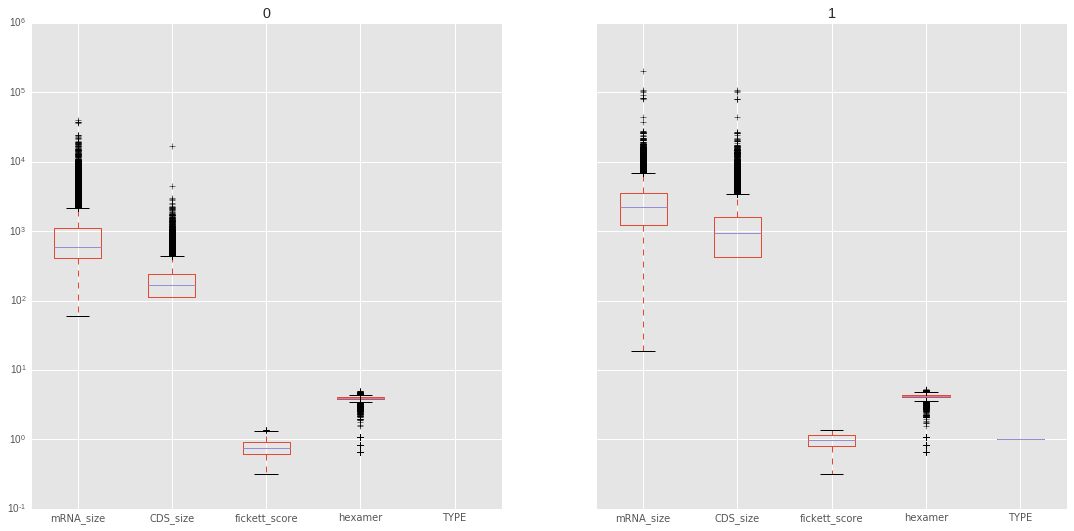

In [253]:
data_full_adj = data_full.copy()
data_full_adj.hexamer +=4
data_full_gr = data_full_adj.groupby("TYPE")
data_full_gr.boxplot(figsize=(18,9), )
plt.semilogy()
plt.show()

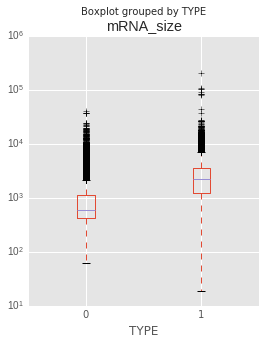

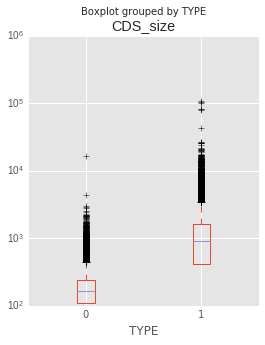

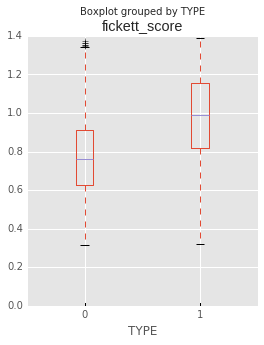

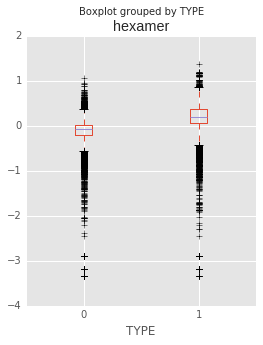

In [261]:
for plt_indx, column in enumerate(('mRNA_size','CDS_size','fickett_score','hexamer')):
    data_full.boxplot(column=column, by='TYPE', figsize=(4,5), )
    if column in ('mRNA_size','CDS_size'):
        plt.semilogy()

In [251]:
np.min(data_full.hexamer)

-3.3444441790599995

In [165]:
scaled_data_train = pd.DataFrame(X_train_scaled, columns=data_full.columns[:-1], index=y_train.index)
scaled_data_train["TYPE"] = list(y_train)
scaled_data_train.head()

,mRNA_size,CDS_size,fickett_score,hexamer,TYPE
sname,,,,,
LNC-CCDC85A-5:1,-0.773526,-0.510834,0.012014,0.048553,0
LNC-RBL2-1:5,-0.666480,-0.487238,-1.137640,-0.184496,0
LNC-TTC21A-1:3,-0.002307,-0.440045,-1.513109,-0.512379,0
LNC-SNX16-4:1,-0.718057,-0.476750,-0.770444,-0.901606,0
LNC-RP11-150O12.6.1-1:11,-0.689836,-0.531809,-0.253533,-0.619309,0


## PCA

### Non-scaled data

In [138]:
from sklearn.decomposition import PCA

pca99 = PCA(n_components=0.99)
pca_vis = PCA(n_components=2)

X_pca = pca99.fit_transform(X_vis2)
pca99.explained_variance_ratio_

array([ 0.90378308,  0.0962169 ])

In [262]:
pca99.components_

array([[ -9.13167379e-01,  -4.07584757e-01,  -3.33311937e-05,
         -4.69259251e-05],
       [ -4.07584761e-01,   9.13167371e-01,   8.35458972e-05,
          9.15448482e-05]])

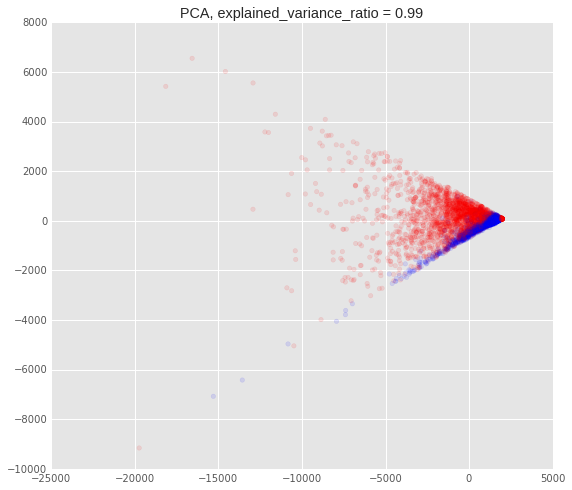

In [145]:
plt.figure(figsize=(8,8))
plt.scatter(X_pca[:,0], X_pca[:,1], color = [col_dict[i] for i in y_vis2], alpha=0.1)
plt.title("PCA, explained_variance_ratio = 0.99")

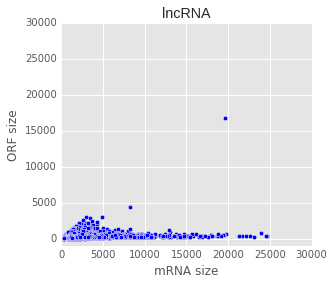

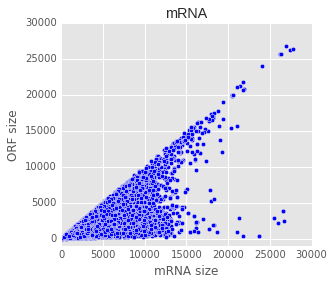

In [274]:
def plot_size_cds(TYPE, title):
    plt.figure(figsize=(4,4))
    plt.scatter(data_full.mRNA_size[data_full.TYPE == TYPE], data_full.CDS_size[data_full.TYPE == TYPE])
    plt.xlim([0,3e4])
    plt.ylim([-1e3,3e4])
    plt.title(title)
    plt.xlabel('mRNA size')
    plt.ylabel('ORF size')

plot_size_cds(0, 'lncRNA')
plot_size_cds(1, 'mRNA')

### Non-scaled data

In [279]:
print(len(scaled_data_train))
scaled_data_train.head()

111676


,mRNA_size,CDS_size,fickett_score,hexamer,TYPE
sname,,,,,
LNC-CCDC85A-5:1,-0.773526,-0.510834,0.012014,0.048553,0
LNC-RBL2-1:5,-0.666480,-0.487238,-1.137640,-0.184496,0
LNC-TTC21A-1:3,-0.002307,-0.440045,-1.513109,-0.512379,0
LNC-SNX16-4:1,-0.718057,-0.476750,-0.770444,-0.901606,0
LNC-RP11-150O12.6.1-1:11,-0.689836,-0.531809,-0.253533,-0.619309,0


In [280]:
scaled_pca = pca99.fit_transform(scaled_data_train.ix[:,:-1].values)

[[ 0.5075911   0.55042805  0.44736058  0.4891306 ]
 [-0.52955401 -0.40123109  0.58242922  0.46836137]]


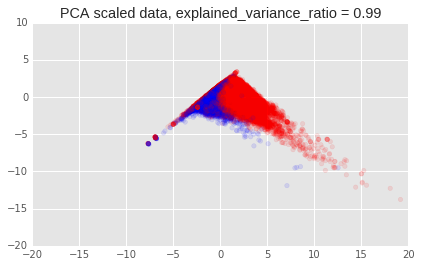

In [287]:
pca2 = PCA(n_components=2)
scaled2 = pca2.fit_transform(scaled_data_train.ix[:, :-1].values)
plt.scatter(scaled2[:,0], scaled2[:,1], color = [col_dict[i] for i in scaled_data_train["TYPE"]], alpha=0.1)
plt.title("PCA scaled data, explained_variance_ratio = 0.99")
plt.ylim([-20,10])
plt.xlim([-20,20])
print(pca2.components_)

In [283]:
pca99.components_

array([[ 0.5075911 ,  0.55042805,  0.44736058,  0.4891306 ],
       [-0.52955401, -0.40123109,  0.58242922,  0.46836137],
       [ 0.04975932,  0.05759472,  0.67504046, -0.73384415],
       [ 0.67782581, -0.72988042,  0.07046342,  0.05349441]])

In [288]:
pca99.explained_variance_ratio_

array([ 0.55713648,  0.25753669,  0.11141578,  0.07391106])

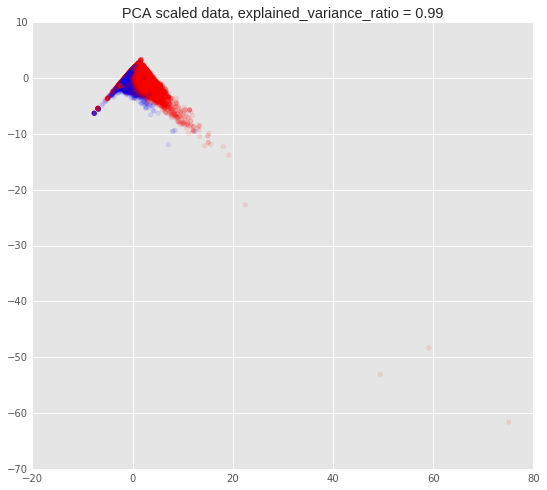

In [282]:
plt.figure(figsize=(8,8))
plt.scatter(scaled_pca[:,0], scaled_pca[:,1], color = [col_dict[i] for i in scaled_data_train["TYPE"]], alpha=0.1)
plt.title("PCA scaled data, explained_variance_ratio = 0.99")

In [589]:
def factor_scatter_matrix(df, factor, palette=None):
    '''Create a scatter matrix of the variables in df, with differently colored
    points depending on the value of df[factor].
    inputs:
        df: pandas.DataFrame containing the columns to be plotted, as well 
            as factor.
        factor: string or pandas.Series. The column indicating which group 
            each row belongs to.
        palette: A list of hex codes, at least as long as the number of groups.
            If omitted, a predefined palette will be used, but it only includes
            9 groups.
    '''
    import matplotlib.colors
    import numpy as np
    from pandas.tools.plotting import scatter_matrix
    from scipy.stats import gaussian_kde

#     if isinstance(factor, basestring):
#         factor_name = factor #save off the name
#         factor = df[factor] #extract column
#         df = df.drop(factor_name,axis=1) # remove from df, so it 
#         # doesn't get a row and col in the plot.

    factor = df[factor]
    classes = list(set(factor))

    if palette is None:
        palette = ['#e41a1c', '#377eb8', '#4eae4b', 
                   '#994fa1', '#ff8101', '#fdfc33', 
                   '#a8572c', '#f482be', '#999999']

    color_map = dict(zip(classes,palette))

    if len(classes) > len(palette):
        raise ValueError('''Too many groups for the number of colors provided.
We only have {} colors in the palette, but you have {}
groups.'''.format(len(palette), len(classes)))

    colors = factor.apply(lambda group: color_map[group])
    axarr = scatter_matrix(df,figsize=(10,10),marker='o',c=colors,diagonal=None)


    for rc in range(len(df.columns)):
        for group in classes:
            y = df[df[factor] == group][rc].values
            gkde = gaussian_kde(y)
            ind = np.linspace(y.min(), y.max(), 1000)
            axarr[rc][rc].plot(ind, gkde.evaluate(ind),c=color_map[group])

    return axarr, color_map

In [586]:
scaled_data_train[scaled_data_train.TYPE == 0]["fickett_score"].values

array([ 0.01201434, -1.13763972, -1.51310933, ..., -0.29096166,
        1.2893202 , -0.81693431])

In [578]:
scaled_data_train.head()

,mRNA_size,CDS_size,fickett_score,hexamer,TYPE
sname,,,,,
LNC-CCDC85A-5:1,-0.773526,-0.510834,0.012014,0.048553,0
LNC-RBL2-1:5,-0.666480,-0.487238,-1.137640,-0.184496,0
LNC-TTC21A-1:3,-0.002307,-0.440045,-1.513109,-0.512379,0
LNC-SNX16-4:1,-0.718057,-0.476750,-0.770444,-0.901606,0
LNC-RP11-150O12.6.1-1:11,-0.689836,-0.531809,-0.253533,-0.619309,0


{0: 'b', 1: 'r'}


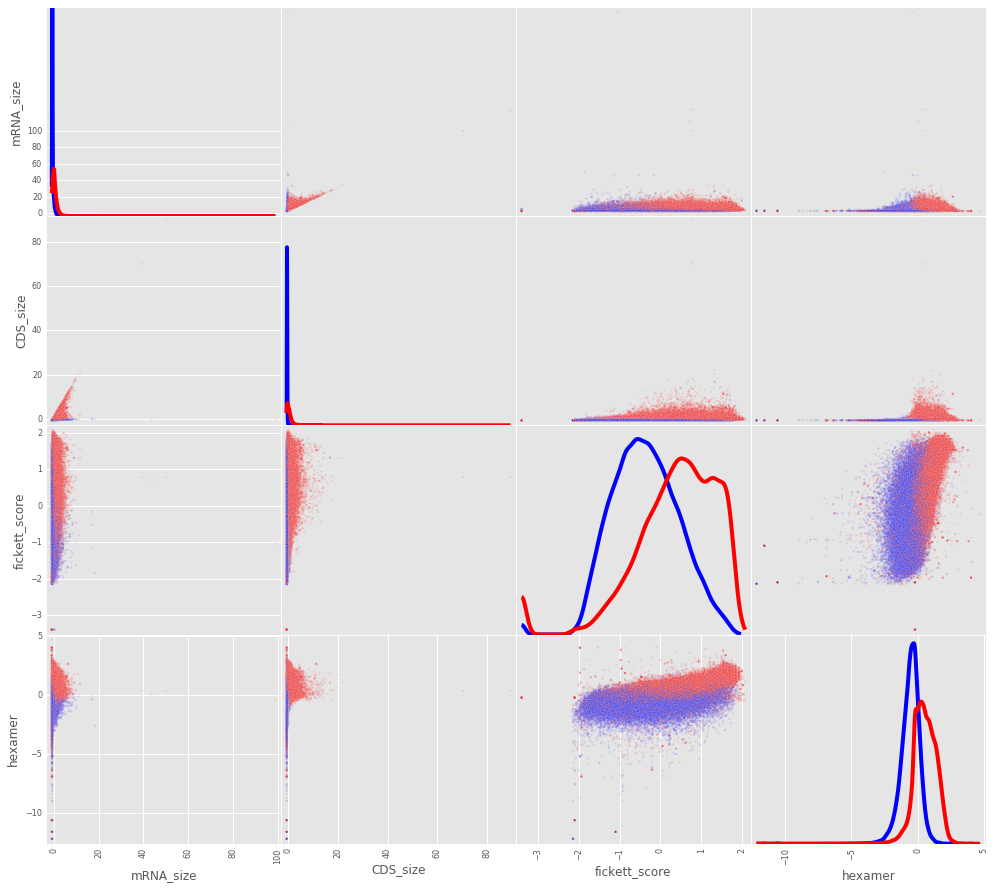

In [601]:
from scipy.stats import gaussian_kde


# palette = ['#e41a1c', '#377eb8', '#4eae4b', 
#                    '#994fa1', '#ff8101', '#fdfc33', 
#                    '#a8572c', '#f482be', '#999999']

palette = ["b", "r"]

classes = list(set(scaled_data_train["TYPE"]))

color_map = dict(zip(classes, palette))
colors = [color_map[i] for i in scaled_data_train["TYPE"]]
print(color_map)

df = scaled_data_train
axarr = scatter_matrix(df.ix[:,:-1], alpha=0.1, figsize=(15, 15), c = colors, diagonal=None, grid=False)
factor = "TYPE"

for rc in range(len(df.columns)-1):
    for group in classes:
        y = df[df[factor] == group].ix[:,rc].values
        gkde = gaussian_kde(y)
        ind = np.linspace(y.min(), y.max(), 1000)
        axarr[rc][rc].plot(ind, gkde.evaluate(ind),c=color_map[group])


plt.show()

['mRNA_size', 'CDS_size', 'fickett_score', 'hexamer']
[[ 1.          0.71587788  0.21700124  0.29091682]
 [ 0.71587788  1.          0.29274534  0.35543004]
 [ 0.21700124  0.29274534  1.          0.55205794]
 [ 0.29091682  0.35543004  0.55205794  1.        ]]


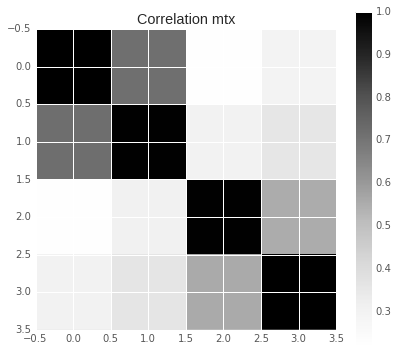

In [100]:
mtx = np.corrcoef(X.T.values)
plt.figure(figsize=(6,6))
plt.imshow(mtx, interpolation="none")
plt.colorbar()
plt.title("Correlation mtx")
print(list(X.columns))
print(mtx)

In [290]:
## Divide data into train/test with stratification ##
## and scale data ##

(X_train, 
 X_test, 
 y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=23, stratify = y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [209]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

get_label = lambda a, thresh: 1 if a>=thresh else 0

def metrics_score(y_test, predicted, threshold = 0.364):
    logloss = log_loss(y_test, predicted)
    auc = roc_auc_score(y_test, predicted[:,1])
    
    y_pred = list(map(lambda x:get_label(x, threshold), predicted[:,1]))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("accuracy:{},\n precision:{},\n recall:{},\n f1_score:{},\n logloss:{},\n roc_auc:{}".\
          format(accuracy, precision, recall, f1, logloss, auc))
       

def plot_scores(optimizer):
    
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
    
def get_model(X_train, X_test, y_train, y_test, balanced = False, fit_intercept=True, penalty = 'l2', cv = 3):
    
    if balanced:
        estimator = LogisticRegression(class_weight="balanced", fit_intercept=fit_intercept, penalty = penalty)
    else:
        estimator = LogisticRegression(fit_intercept=fit_intercept, penalty=penalty)
        
    param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
    optimizer = GridSearchCV(estimator, param_grid, cv = cv)
    optimizer.fit(X_train, y_train)
    plot_scores(optimizer)
    
    print(optimizer.best_params_)
    
#     metrics_score(y_test, optimizer.best_estimator_.predict_proba(X_test))
#     auc = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test)[:,1])
#     print("roc_auc_score:", auc)
#     return optimizer.best_estimator_

    cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.3, random_state=0)
    for scoring in ["log_loss", "roc_auc", "precision", "recall"]:
        scores = cross_val_score(optimizer.best_estimator_, X_train, y_train, cv=cv, scoring=scoring)
        print("metrics:{}, score:{} +/- {}\n".format(scoring, np.round(scores.mean(),4), np.round(scores.std(),4)))
        
    return optimizer.best_estimator_

### Scaled data:

In [299]:
from sklearn.metrics import log_loss
log_loss([0,1], [0,1])

9.9920072216264148e-16

In [302]:
!python --version
import sklearn

Python 3.4.3


In [303]:
sklearn.__version__

'0.17.1'

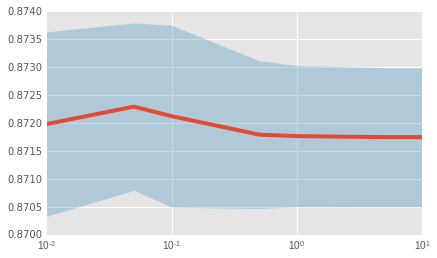

{'C': 0.05}
metrics:log_loss, score:-0.3549 +/- 0.0019

metrics:roc_auc, score:0.907 +/- 0.0014

metrics:precision, score:0.9357 +/- 0.0016

metrics:recall, score:0.7976 +/- 0.0019



In [291]:
model_scaled = get_model(X_train_scaled, X_test_scaled, y_train, y_test, balanced=True, cv = 5)

In [293]:
print("\t".join(X.columns))
print(model_scaled.coef_[0])

mRNA_size	CDS_size	fickett_score	hexamer
[ 0.09744148  5.08068827 -0.15402477  1.0193206 ]


### Non-scaled data:

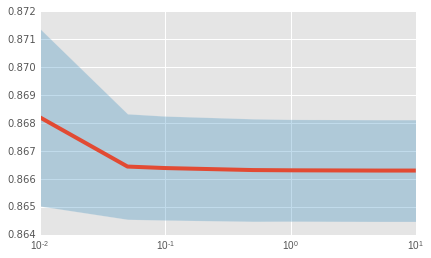

{'C': 0.01}
metrics:log_loss, score:-0.3609 +/- 0.0062

metrics:roc_auc, score:0.8968 +/- 0.0034

metrics:precision, score:0.937 +/- 0.005

metrics:recall, score:0.7843 +/- 0.0079



In [292]:
model = get_model(X_train, X_test, y_train, y_test, balanced=True)

In [294]:
print("\t".join(X.columns))
print(model.coef_[0])

mRNA_size	CDS_size	fickett_score	hexamer
[  1.18333828e-05   4.89683167e-03  -2.98635239e-01   2.72394181e+00]


# lncPedia 3.1 trying

In [515]:
poly_data = pd.read_csv("../data/spec_counts_samples.csv", sep = "\t", index_col=0)
print(poly_data.shape)
poly_data.head()

(60, 44)


,Peptide.sequence,Ctrl_005_MGFPeaklist,Ctrl_00K_MGFPeaklist,I305_20140905_SWP100_CMBiogel20_B1_5-40_120min_7uLinj_1_MGFPeaklist,I311_20140905_SMP100_CMBiogel20_B1_5-40_120min_7uLinj_1_MGFPeaklist,I315_20140904_SWP100_CMBio-gel20_B2_5-40_120min_7uLinj_1-2_MGFPeaklist,I321_20140904_SMP100_CMBio-gel20_B2_5-40_120min_7uLinj_1_MGFPeaklist,I325_20140905_SWP100_CMBiogel20_B3_5-40_120min_7uLinj_1_MGFPeaklist,I331_20140905_SMP100_CMBiogel20_B3_5-40_120min_7uLinj_1_MGFPeaklist,N027_MGFPeaklist,...,N182_MGFPeaklist,N208_MGFPeaklist,N209_MGFPeaklist,N211_MGFPeaklist,N212_MGFPeaklist,N214_MGFPeaklist,N216_MGFPeaklist,N218_MGFPeaklist,N220_MGFPeaklist,N221_MGFPeaklist
Protein.accession.numbers,,,,,,,,,,,,,,,,,,,,,
lnc-NXPH2-3:3_(+1),APDLTLAILL,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,...,2.0,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN
lnc-LRRTM3-14:2_(-3),AEEHEGWEVPLQLFLENT,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lnc-CHRAC1-1:1_(+1),APVAEASISR,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lnc-NR2F1-6:1_(+2),PSALKSEEAQSGGW,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lnc-EPB41-1:1_(+2),FVPAPRTGHGGSDI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [311]:
poly_proteins = list(map(lambda x: x[:-5].upper(), list(poly_data.index)))
poly_proteins[:5]

['LNC-NXPH2-3:3',
 'LNC-LRRTM3-14:2',
 'LNC-CHRAC1-1:1',
 'LNC-NR2F1-6:1',
 'LNC-EPB41-1:1']

In [306]:
lncRNA.index[:10]

Index(['LNC-C8ORF56-1:8', 'LNC-TTLL7-2:5', 'LNC-CLEC18B-3:5', 'LNC-GPR119-1:1',
       'LNC-CHAD-4:3', 'LNC-HES5-1:2', 'LNC-C1ORF200-1:1', 'LNC-C15ORF40-2:1',
       'LNC-CDH11-3:4', 'LNC-LSMD1-1:1'],
      dtype='object', name='sname')

In [389]:
def intersection(list1, list2):
    if len(list1) > len(list2):
        list1,list2 = list2,list1
    
    res = []
    for i in list1:
        if i in list2:
            res.append(i)
    
#     print("intersection length:", len(res))
    return res

In [675]:
from sklearn.cross_validation import StratifiedKFold

def get_pred_thresh(predicted, thresh=0.5):
    
    """
    threshold for 1 class
    
    """
    
    get_label = lambda a, thresh: 1 if a>=thresh else 0
    y_pred = list(map(lambda x:get_label(x, thresh), predicted[:,1]))
    return y_pred


def find_lnc(scale = True, folds = 3, threshold = 0.364, estimator = "default", find_optimal_cutoff = False):

    predicted_lnc = []

    X = data_full.ix[:, :-1]
    y = data_full.TYPE

    skf = StratifiedKFold(y.values, n_folds=folds)
    
    if estimator == "default":
        estimator = LogisticRegression(C = 0.05)
    
    metrics = {}
    
    names = ["roc_auc", "acc", "rec"]
    for n in names:
        metrics[n] = []
    
    cutoffs = []
    
    for train_index, test_index in skf:

        test_names = X.index[test_index]
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        
        if scale:
            X_train_sc = scaler.fit_transform(X_train)
            X_test_sc = scaler.transform(X_test)
        else:
            X_train_sc = X_train
            X_test_sc = X_test
            
        estimator.fit(X_train_sc, y_train)
        y_pred = estimator.predict_proba(X_test_sc)
        
        if find_optimal_cutoff:
            thresh = Find_Optimal_Cutoff(y_test, y_pred[:,1])
            cutoffs.append(thresh)
            threshold = cutoffs[0]
        
        roc_auc = roc_auc_score(y_test, y_pred[:,1])
        acc = accuracy_score(y_test, get_pred_thresh(y_pred, threshold))
        rec = recall_score(y_test, get_pred_thresh(y_pred, threshold))
        

        for i in range(len(y_test)):
            if y_pred[i,1]>=threshold:
                predicted_lnc.append(test_names[i])
                
        metrics["roc_auc"].append(roc_auc)
        metrics["acc"].append(acc)
        metrics["rec"].append(rec)
        

    if find_optimal_cutoff:
        print("Optimal cutoffs:", cutoffs)
        print("Used:", cutoffs[0])
        print("Mean_cutoffs: ", np.mean(cutoffs))
        print("-----------")
        
        
    predicted_lnc = list(set(predicted_lnc))
    
    print(estimator.get_params())
    print("roc_auc_score: ", np.mean(metrics["roc_auc"]))
    print("accuracy: ", np.mean(metrics["acc"]))
    print("recall:", np.mean(metrics["rec"]))
    print("classes_: ", estimator.classes_)
    print("*******************")
    
    print("Predicted_length: ",len(predicted_lnc))
    print("True mRNA among predicted: ", len(intersection(mRNA.index, predicted_lnc)))
    print("poly_intersection:", len(intersection(poly_proteins, predicted_lnc)))
    print("True_length/Predicted_mRNA_length:",len(intersection(mRNA.index, predicted_lnc))/len(predicted_lnc))
    
    return predicted_lnc, np.mean(metrics["roc_auc"]), np.mean(metrics["acc"]), np.mean(metrics["rec"])

In [604]:
find_lnc(scale = True, threshold=0.343)

{'verbose': 0, 'solver': 'liblinear', 'warm_start': False, 'dual': False, 'C': 0.05, 'multi_class': 'ovr', 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'class_weight': None, 'penalty': 'l2', 'n_jobs': 1, 'tol': 0.0001, 'random_state': None}


In [431]:
prediction_scl = find_lnc(scale = True, threshold=0.343)

roc_auc_score:  0.904951650437
accuracy:  0.862504701015
recall: 0.740165475743
*******************
roc_auc_score:  0.906885161283
accuracy:  0.869180142911
recall: 0.774990597969
*******************
roc_auc_score:  0.91050888494
accuracy:  0.854074993418
recall: 0.723682725939
*******************
Predicted_length: 99107
True lnc: 78235
poly_intersection: 56
True_length/Predicted_lnc_length: 0.789399336071115


In [425]:
from sklearn.metrics import roc_curve

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

In [426]:
Find_Optimal_Cutoff(test, pred[:,1])

[0.65722892038879754]

In [487]:
def dummy_func(lst):
    lol = lambda x: not np.isnan(x)
    return np.array(list(map(lol, lst)))

In [495]:
poly_data_modif = pd.Series([sum(poly_data.values[i, 1:][dummy_func(poly_data.values[i, 1:])]) for i in range(len(poly_data))], index=poly_data.index)

In [506]:
intersct = intersection(poly_proteins, prediction_scl)
len(intersct)

56

In [507]:
len(poly_data_modif[intersct])

62

In [541]:
set(poly_data_modif.index) - set(intersct)

{'LNC-C17ORF89-1:1', 'LNC-HSCB-1:18', 'LNC-MRPS22-3:1', 'LNC-RASGRP1-3:2'}

In [520]:
names = list(set(poly_data.index))
indexes = []
for i in poly_data.index:
    if i in indexes:
        print(i)
    else:
        indexes.append(i)

lnc-TRIP10-4:1_(-3)
lnc-TRIP10-4:1_(-3)


In [522]:
poly_data.ix["lnc-TRIP10-4:1_(-3)", :]

,Peptide.sequence,Ctrl_005_MGFPeaklist,Ctrl_00K_MGFPeaklist,I305_20140905_SWP100_CMBiogel20_B1_5-40_120min_7uLinj_1_MGFPeaklist,I311_20140905_SMP100_CMBiogel20_B1_5-40_120min_7uLinj_1_MGFPeaklist,I315_20140904_SWP100_CMBio-gel20_B2_5-40_120min_7uLinj_1-2_MGFPeaklist,I321_20140904_SMP100_CMBio-gel20_B2_5-40_120min_7uLinj_1_MGFPeaklist,I325_20140905_SWP100_CMBiogel20_B3_5-40_120min_7uLinj_1_MGFPeaklist,I331_20140905_SMP100_CMBiogel20_B3_5-40_120min_7uLinj_1_MGFPeaklist,N027_MGFPeaklist,...,N182_MGFPeaklist,N208_MGFPeaklist,N209_MGFPeaklist,N211_MGFPeaklist,N212_MGFPeaklist,N214_MGFPeaklist,N216_MGFPeaklist,N218_MGFPeaklist,N220_MGFPeaklist,N221_MGFPeaklist
Protein.accession.numbers,,,,,,,,,,,,,,,,,,,,,
lnc-TRIP10-4:1_(-3),ESQYSIITPNILRLESEETMVLEAHDAQGD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lnc-TRIP10-4:1_(-3),ESQYSIITPNILRLESEETMVLEAHD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lnc-TRIP10-4:1_(-3),ESQYSIITPNILRLESEETMVLEAH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Random Forest

In [563]:
from sklearn.ensemble import RandomForestClassifier as RF

In [660]:
rf = RF(n_estimators=10, random_state=0)
lnc_rf = find_lnc(scale = False, folds = 3, threshold = 0.5, estimator = rf, find_optimal_cutoff=True)

Optimal cutoffs: [[0.39999999999999997], [0.59999999999999987], [0.29999999999999993]]
Used: [0.39999999999999997]
Mean_cutoffs:  0.433333333333
-----------
{'verbose': 0, 'bootstrap': True, 'warm_start': False, 'max_features': 'auto', 'min_samples_split': 2, 'criterion': 'gini', 'n_estimators': 10, 'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': None, 'class_weight': None, 'max_depth': None, 'n_jobs': 1, 'oob_score': False, 'min_samples_leaf': 1, 'random_state': 0}
roc_auc_score:  0.93384222076
accuracy:  0.869021939807
recall: 0.883776596649
classes_:  [0 1]
*******************
Predicted_length: 82123
True lnc: 11625
poly_intersection: 15
True_length/Predicted_lnc_length: 0.1415559587448096


In [569]:
intersct = intersection(poly_proteins, lnc_rf)
poly_data_modif[list(set(poly_data_modif.index) - set(intersct))].sort_values()[-20:]

LNC-C17ORF89-1:1    1.0
LNC-NR2F1-6:1       1.0
LNC-MANEA-3:2       1.0
LNC-RASGRP1-3:2     1.0
LNC-RPL7A-3:1       1.0
LNC-YWHAH-2:2       1.0
LNC-PIEZO2-7:1      1.0
LNC-MRPS22-3:1      1.0
LNC-HSCB-1:18       5.0
dtype: float64

In [566]:
test, pred = find_lnc(scale = False, folds = 2, threshold = 0.5, estimator=rf)
Find_Optimal_Cutoff(test, pred[:,1])

[0.40333333333333332]

{'verbose': 0, 'bootstrap': True, 'warm_start': False, 'max_features': 'auto', 'min_samples_split': 2, 'criterion': 'gini', 'n_estimators': 5, 'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': None, 'class_weight': None, 'max_depth': None, 'n_jobs': 1, 'oob_score': False, 'min_samples_leaf': 1, 'random_state': 0}
roc_auc_score:  0.933118220813
accuracy:  0.889211326455
recall: 0.864007135988
classes_:  [0 1]
*******************
Predicted_length:  75748
True mRNA among predicted:  68921
poly_intersection: 8
True_length/Predicted_mRNA_length: 0.9098722078470719
{'verbose': 0, 'bootstrap': True, 'warm_start': False, 'max_features': 'auto', 'min_samples_split': 2, 'criterion': 'gini', 'n_estimators': 10, 'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': None, 'class_weight': None, 'max_depth': None, 'n_jobs': 1, 'oob_score': False, 'min_samples_leaf': 1, 'random_state': 0}
roc_auc_score:  0.94180780921
accuracy:  0.89311635151
recall: 0.868883717274
classes_:  [0 1]
*******************
P

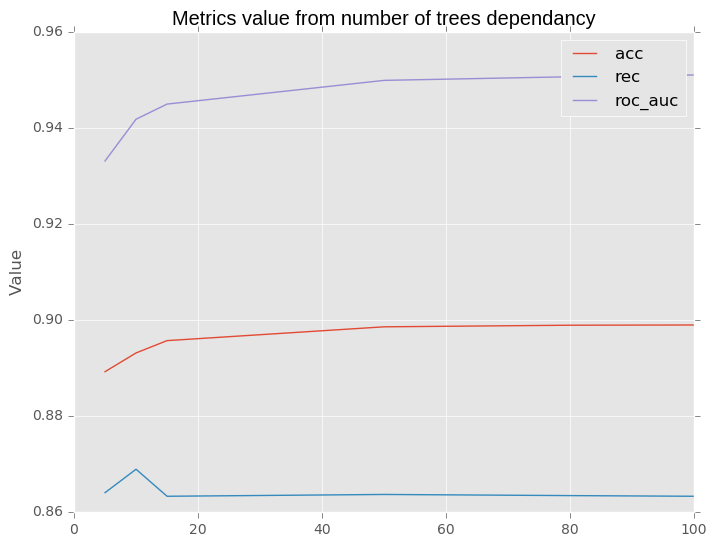

In [676]:
##### Building metrics_val from numb of trees dependancy ######


metrics_dict = {}
names = ["roc_auc", "acc", "rec"]

for name in names:
    metrics_dict[name] = []

range_lst = [5,10,15,50,80,100,300,500,1000]
    
for i in range_lst:
    rf = RF(n_estimators=i, random_state=0)
    lst, roc_auc, acc, rec = find_lnc(scale = False, folds = 2, threshold = 0.5, estimator=rf)
    metrics_dict["acc"].append(acc)
    metrics_dict["roc_auc"].append(roc_auc)
    metrics_dict["rec"].append(rec)
    
# plt.rcdefaults()

df_result = pd.DataFrame(metrics_dict)
df_result.index = range_lst

plt.style.use('ggplot')
plt.plot(df_result.ix[:100,:])
plt.ylabel("Value")
plt.title("Metrics value from number of trees dependancy")
# plt.xlabel("Number of trees")
plt.legend(df_result.columns)
plt.show()

Optimal cutoffs: [[0.40952380952380951], [0.39999999999999997]]
Used: [0.40952380952380951]
Mean_cutoffs:  0.404761904762
-----------
{'verbose': 0, 'bootstrap': True, 'warm_start': False, 'max_features': 'auto', 'min_samples_split': 2, 'criterion': 'gini', 'n_estimators': 5, 'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': None, 'class_weight': None, 'max_depth': None, 'n_jobs': 1, 'oob_score': False, 'min_samples_leaf': 1, 'random_state': 0}
roc_auc_score:  0.933118220813
accuracy:  0.888114413742
recall: 0.865323437907
classes_:  [0 1]
*******************
Predicted_length:  76133
True mRNA among predicted:  69026
poly_intersection: 8
True_length/Predicted_mRNA_length: 0.9066502042478295
Optimal cutoffs: [[0.40333333333333332], [0.30666666666666664]]
Used: [0.40333333333333332]
Mean_cutoffs:  0.355
-----------
{'verbose': 0, 'bootstrap': True, 'warm_start': False, 'max_features': 'auto', 'min_samples_split': 2, 'criterion': 'gini', 'n_estimators': 10, 'min_weight_fraction_leaf': 0.

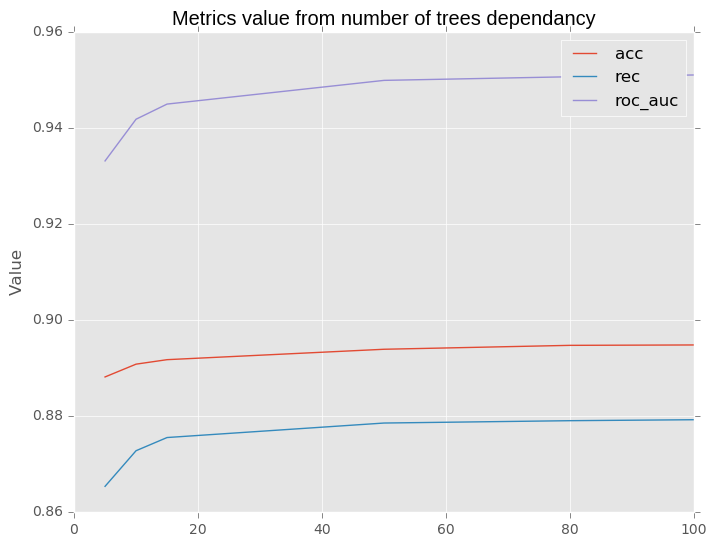

In [679]:
##### Building metrics_val from numb of trees dependancy ######


metrics_dict = {}
names = ["roc_auc", "acc", "rec"]

for name in names:
    metrics_dict[name] = []

range_lst = [5,10,15,50,80,100,300,500,1000]
    
for i in range_lst:
    rf = RF(n_estimators=i, random_state=0)
    lst, roc_auc, acc, rec = find_lnc(scale = False, folds = 2, threshold = 0.5, estimator=rf, find_optimal_cutoff=True)
    metrics_dict["acc"].append(acc)
    metrics_dict["roc_auc"].append(roc_auc)
    metrics_dict["rec"].append(rec)
    
# plt.rcdefaults()

df_result = pd.DataFrame(metrics_dict)
df_result.index = range_lst

plt.style.use('ggplot')
plt.plot(df_result.ix[:100,:])
plt.ylabel("Value")
plt.title("Metrics value from number of trees dependancy")
# plt.xlabel("Number of trees")
plt.legend(df_result.columns)
plt.show()

In [678]:
intersct = intersection(poly_proteins, lst)
poly_data_modif[list(set(intersct))].sort_values()

LNC-MANEA-3:2      1.0
LNC-NR2F1-6:1      1.0
LNC-RASGRP1-3:2    1.0
LNC-YWHAH-2:2      1.0
LNC-PIEZO2-7:1     1.0
LNC-MRPS22-3:1     1.0
LNC-HSCB-1:18      5.0
dtype: float64

In [694]:
seq = 'atatattacacacacacatatatattaacacacggtttgggttggtgcctggtcgt'
seq = seq.upper()
seq

'ATATATTACACACACACATATATATTAACACACGGTTTGGGTTGGTGCCTGGTCGT'

In [696]:
dict_nucl = {"A":0, "T":0, "G":1, "C":1}
GC = np.sum([dict_nucl[c] for c in seq])/len(seq)
GC

0.39285714285714285